# Mask R-CNN for GTSDB

Documentation for a Mask R-CNN can be found [here](https://arxiv.org/abs/1703.06870). The work for this notebook followed this [tutorial](https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/).

The base layout was taken from the tutorial, as well as the base for the plot function at the end.

The github for Mask R-CNN is originally [here](https://github.com/matterport/Mask_RCNN/) and a fork of this from [here](https://github.com/ahmedfgad/Mask-RCNN-TF2) was used due to there being various version issues that needed to be handled to get it to work properly.

In order to get traffic sign recognition, a few attempts were made with image manipulation and sign class IDs. At base with no manipulation and the full sign set, as expected from the results of the previous section, the Mask RCNN did not perform well at differentiating the signs themselves, but did well to pick up sign locations with base performance at ~85%. To extract masks, the minimum confidence in sign recognition was set to 0.1 Normalizing the image contrast and brightness helps with the sign identification a little bit when using all sign categories, and also greatly reduces the odds of finding an extra box. The biggest improvement, since classification isn't performed here, was to just classify off of general sign shape and color (red circle, red triangle up, red triangle down, blue circle, etc). This significantly improved the performance for identification, making the final outcome 93% effective at properly identifying signs. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
import glob
from sklearn import metrics
from tensorflow.keras import utils

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

## Class Labels

Set up the class labels for the Mask R-CNN. Can use class labels or subclass labels for the net. Subclass labels are setup based off the general shape of the signs, with the four odd balls getting their own category. 

In [2]:
label_df = pd.read_csv(f'../FullIJCNN2013/gt.txt',names=['file','x1','y1','x2','y2','class'],delimiter = ';')
for i in range(label_df[label_df['file'] == '00600.ppm'].shape[0]):
    print('test')

In [3]:
#blue circle signs
zero = [33,34,35,36,37,38,39,40]
#b/w stripe circle
one = [6,32,41,42]
#danger
two = [17]
#diamond
three = [12]
#red circle
four = [0,1,2,3,4,5,7,8,9,10,15,16]
#red down triangle
five = [13]
#red up triangle
six = [11,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
#stop
seven = [14]

subclass_list = [zero, one, two, three, four, five, six, seven]

In [4]:
# implement image subclass from above
def find_subclass(classid):
    for i in range(8):
        if classid in subclass_list[i]:
            return i
label_df['sub_class']=label_df['class'].map(find_subclass)

## Make information files

Making xml files for easier read in for the mask parsing. Could be other methods, I just have mine setup this way to make it easier to follow intial tutorial. 

In [6]:
for j in range(900):
    image_id = str(j).rjust(5,'0')
    f_out = open(f'FullIJCNN2013/xml/{image_id}.xml','w')
    f_out.write(f"""<annotation>
    <folder>{f'FullIJCNN2013/'}</folder>
    <path>{f'FullIJCNN2013/{image_id}.ppm'}</path>
    <source>
        <database>Unknown</database>
    </source>
    <filename>{str(j).rjust(5,'0')}.ppm</filename>
    <size>
        <width>1360</width>
        <height>800</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
""")
    temp_df = label_df[label_df['file'] == image_id+'.ppm']
    for i in range(temp_df.shape[0]):
        f_out.write(f"""    <object>
        <name>{temp_df.iloc[i,6]+1}</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{temp_df.iloc[i,1]}</xmin>
            <ymin>{temp_df.iloc[i,2]}</ymin>
            <xmax>{temp_df.iloc[i,3]}</xmax>
            <ymax>{temp_df.iloc[i,4]}</ymax>
        </bndbox>
    </object>
""")        
    f_out.write("</annotation>")
    f_out.close()
        
        

          file  x1   y1   x2   y2  class  sub_class
852  00601.ppm  82  450  145  508      7          4


# Create dataset class

Create dataset class used for mask R-CNN, as well as configuration information

In [8]:
class RoadDataset(Dataset):
    #Load the model
    #is_train loads the set type, dataset_dir is where images are
    #train_list and test_list to differntiate which file is what set
    def load_dataset(self, dataset_dir,is_train=True):
        #Two categories, normal and not
        for i in range(8):
            self.add_class('dataset',i+1,str(i+1))
        files = glob.glob(dataset_dir + 'normalized_full/*.ppm')
        for file in files:
            image_idstr = file[-14:-9]
            image_id = int(image_idstr)
            if is_train and image_id >= 600:
                continue
            elif not is_train and image_id < 600:
                continue
            img_path = file
            ann_path = f'{dataset_dir}xml/{image_idstr}.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, 
                       annotation=ann_path,class_ids=[0,1,2])
        
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        # print(boxes)
        return boxes, width, height

    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = int(box[4])
            class_ids.append(self.class_names.index(str(box[4])))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


In [9]:
# define a configuration for the model
class RoadConfig(Config):
    # define the name of the configuration
    NAME = "road_cfg"
    # number of classes (background + num signs) (8 for sub cats, 43 for all signs)
    NUM_CLASSES = 1 + 8
    DETECTION_MIN_CONFIDENCE = 0.5
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131
 

Very low confidence threshold since we want signs to feed back to GTSRB CNN. Num classes should change depending on whether or not subclasses are used (8 or 43)

In [10]:
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "road_cfg"
    # number of classes (background + num signs)
    NUM_CLASSES = 1 + 8
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.1


## Load training and test sets

In [11]:
#make train dataset
train_set = RoadDataset()
train_set.load_dataset('../FullIJCNN2013/',is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 600


In [12]:
#make test dataset
test_set = RoadDataset()
test_set.load_dataset('../FullIJCNN2013/',is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


Test: 300


## Configure and Train model

In [13]:
config = RoadConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [14]:
# define the model
model = MaskRCNN(mode='training', model_dir='../models', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5',
                   by_name=True
                   ,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"]
                  )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [16]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=45, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./models\road_cfg20210920T2311\mask_rcnn_road_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistrib

131/131 [==============================] - 158s 1s/step - batch: 65.0000 - size: 2.0000 - loss: 0.3135 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0784 - val_loss: 0.6777 - val_rpn_class_loss: 0.0058 - val_rpn_bbox_loss: 0.1031 - val_mrcnn_class_loss: 0.0180 - val_mrcnn_bbox_loss: 0.0570 - val_mrcnn_mask_loss: 0.1549
Epoch 39/45
131/131 [==============================] - 157s 1s/step - batch: 65.0000 - size: 2.0000 - loss: 0.3034 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0770 - val_loss: 0.8131 - val_rpn_class_loss: 0.0168 - val_rpn_bbox_loss: 0.1509 - val_mrcnn_class_loss: 0.0219 - val_mrcnn_bbox_loss: 0.0564 - val_mrcnn_mask_loss: 0.1605
Epoch 40/45
131/131 [==============================] - 157s 1s/step - batch: 65.0000 - size: 2.0000 - loss: 0.3107 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0072 -

# Make Predictions with final fit

Directory shown is last one used, update based off of the resulting directory from your fit performed above, which is auto generated when initialized. 

In [17]:
#initiate config
cfg = PredictionConfig()
model_inf = MaskRCNN(mode='inference', model_dir='../models/road_cfg20210920T2311/', config=cfg)
# load model weights
model_path = '../models/road_cfg20210920T2311/mask_rcnn_road_cfg_0045.h5'
model_inf.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Re-starting from epoch 45


Display code from the original Mask R-CNN repository with minor tweaks. This will recognize and draw predicted masks. 

In [18]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: dataset.695  (95) ./FullIJCNN2013/normalized_full\00695_norm.ppm
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    4.00000  max:    4.00000  int32
gt_bbox                  shape: (1, 4)                min:  501.00000  max:  620.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    1.00000  max:    1.00000  bool


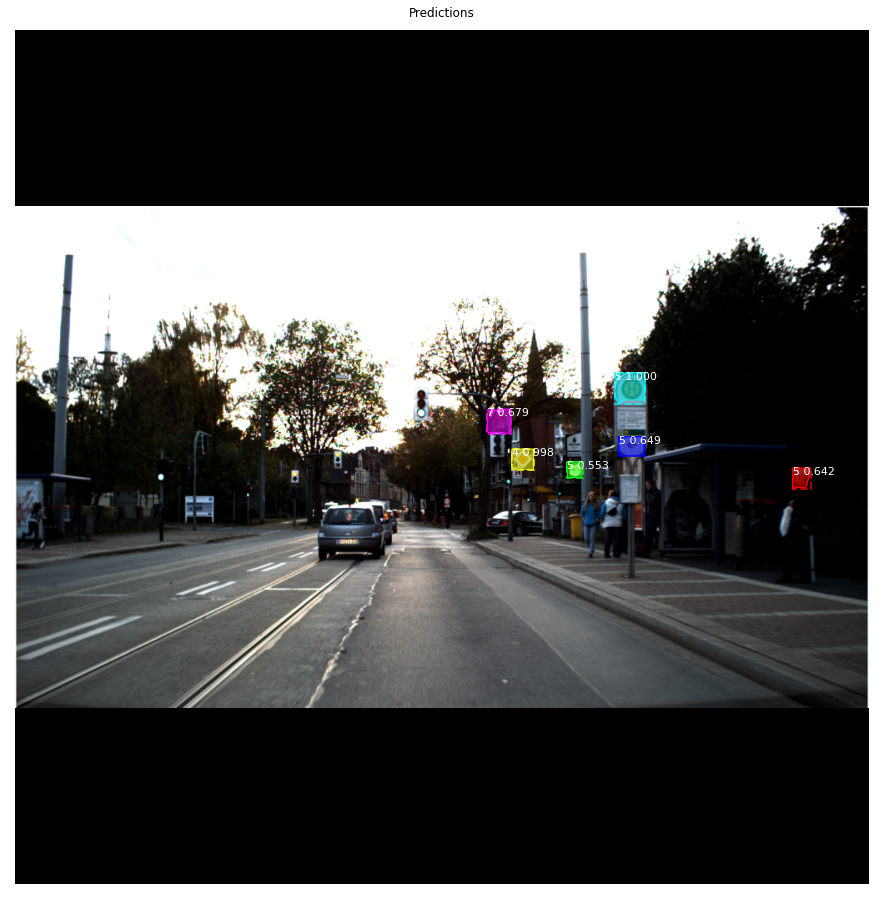

In [19]:
image_id = random.choice(test_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, image_id)
info = test_set.image_info[image_id]

print("image ID: {}.{}  ({}) {}".format(info["source"], info["id"], 
                                            image_id, test_set.image_reference(image_id)))
results = model_inf.detect([image], verbose=1)

ax = get_ax(1)
r = results[0]
# if len(r['class_ids'] > 0):
#     print(r['class_ids'],label_df.iloc[image_id][7]+1)

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


## Test performance

This shows the side by side comparison of input mask and the fit mask. Taken from the mentioned tutorial. 

In [20]:
#n_start and n_images help to allow for more control of output images and how many in each cycle
def plot_actual_vs_predicted(dataset, model, cfg,n_start, n_images=20):
    # load image and mask
    pyplot.figure(figsize=(16,8))
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i+n_start)
        mask, _ = dataset.load_mask(i+n_start)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        print(i+n_start,yhat['class_ids'])
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()
 

0 []


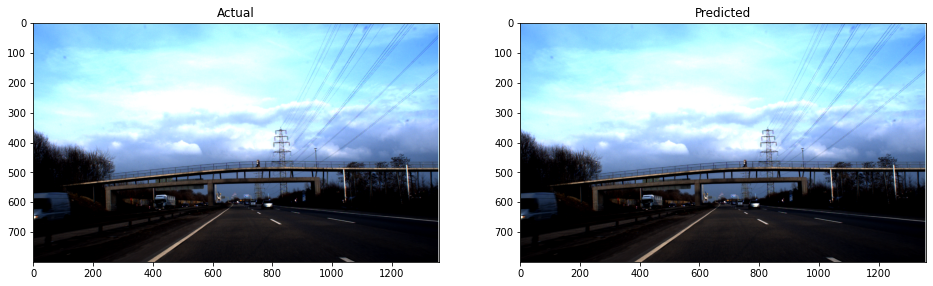

1 [5 5]


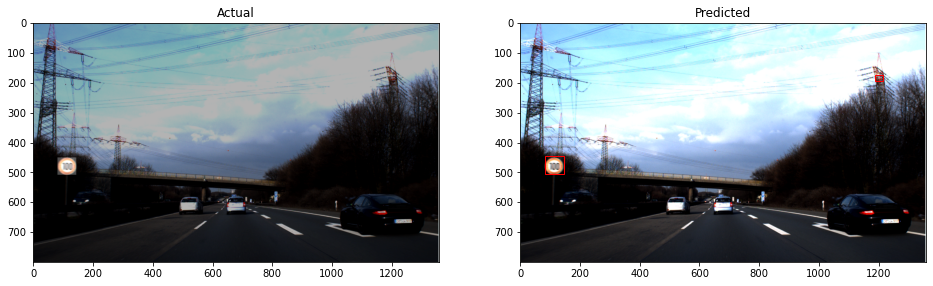

2 [5 5]


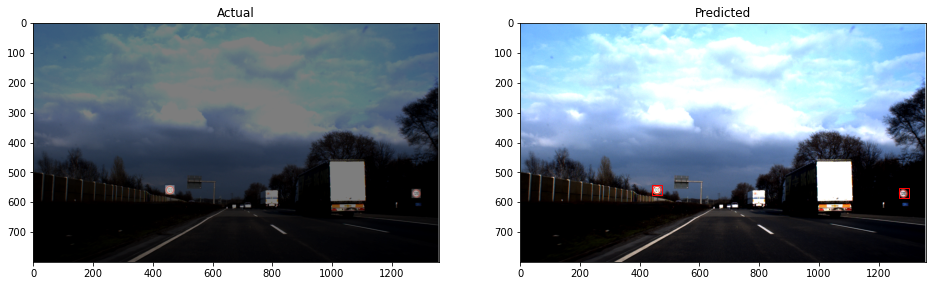

3 [5]


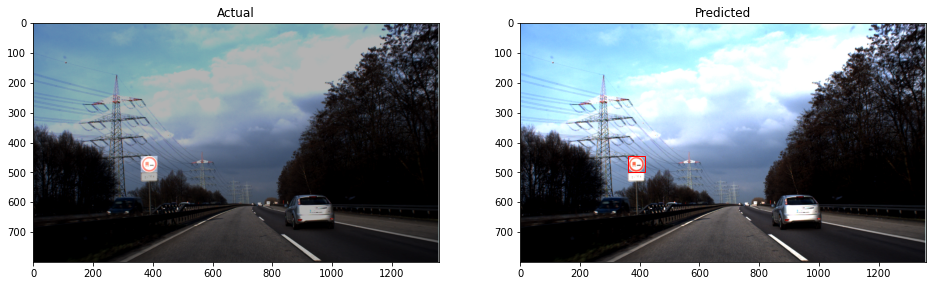

4 [7]


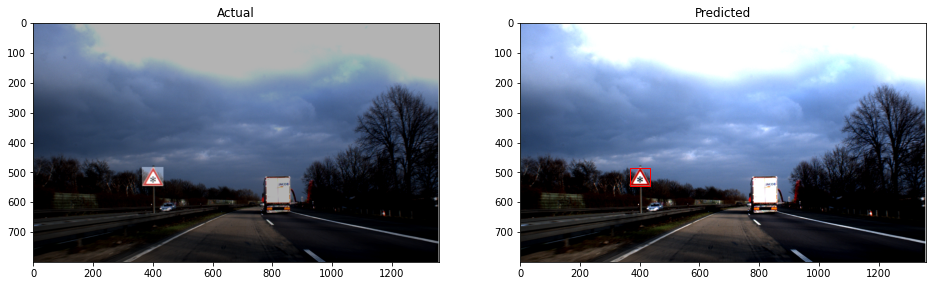

5 [5]


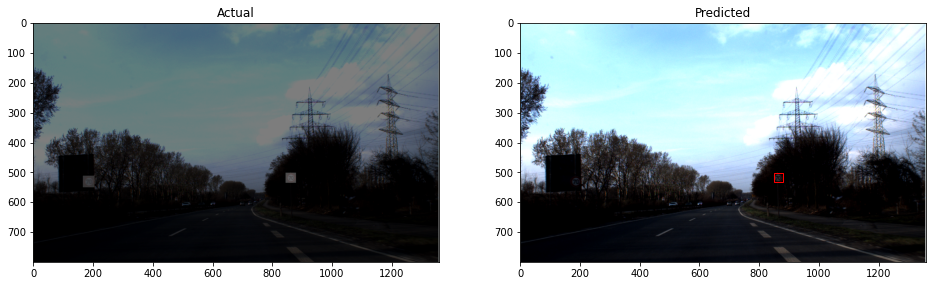

6 [1]


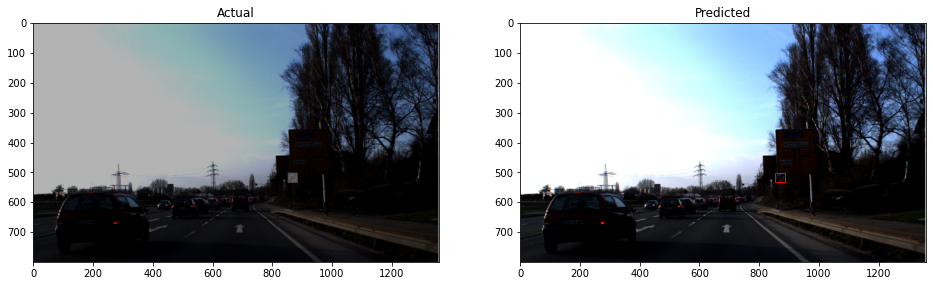

7 [7]


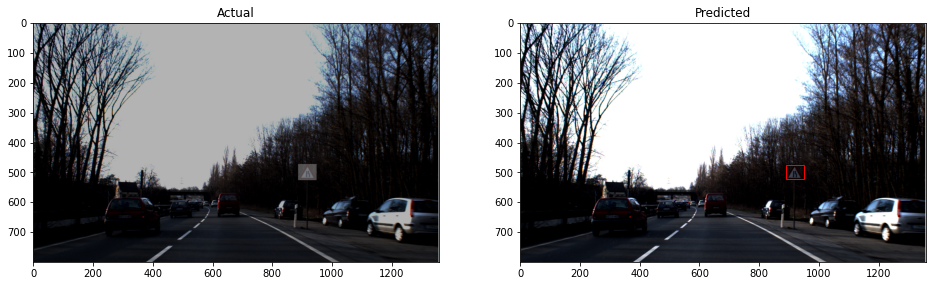

8 [4 5]


9 [5 5]


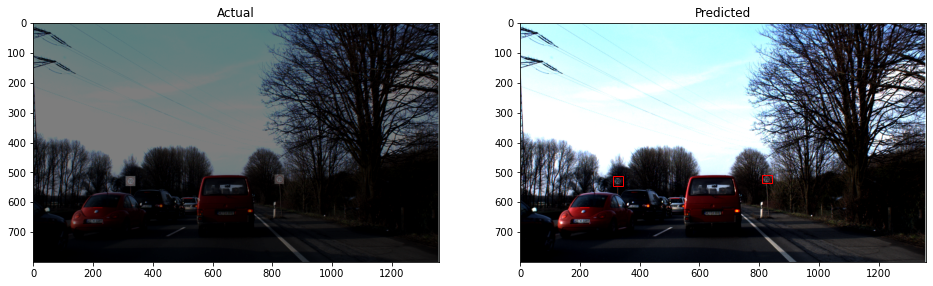

10 [5 4 3 3]


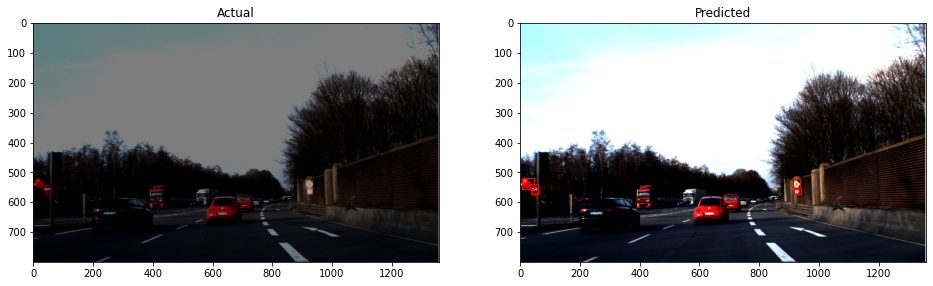

11 [5 5 1]


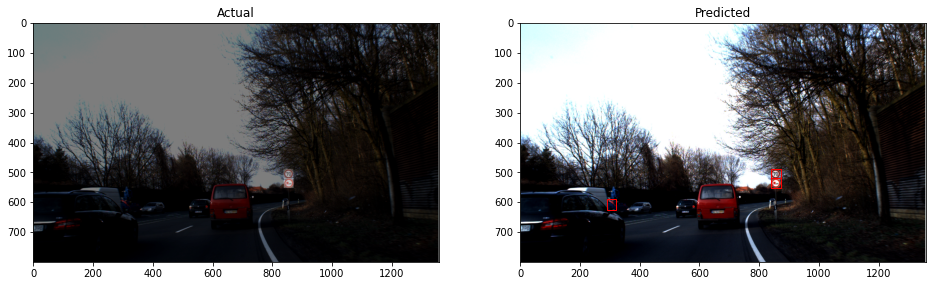

12 [1 5 3 1 1]


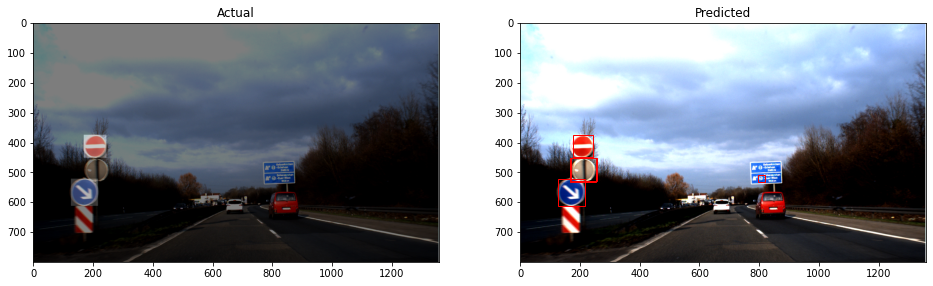

13 [5 5]


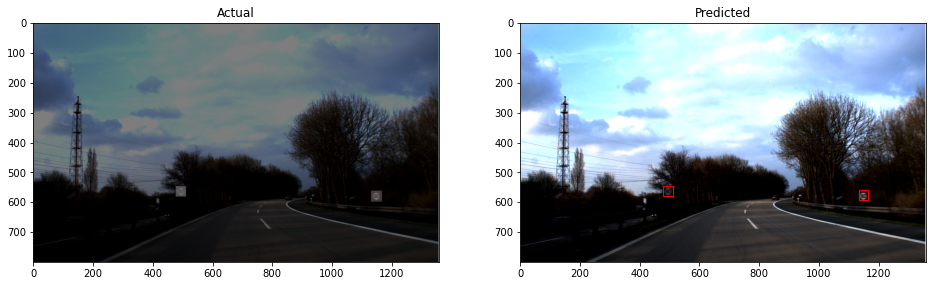

14 [5]


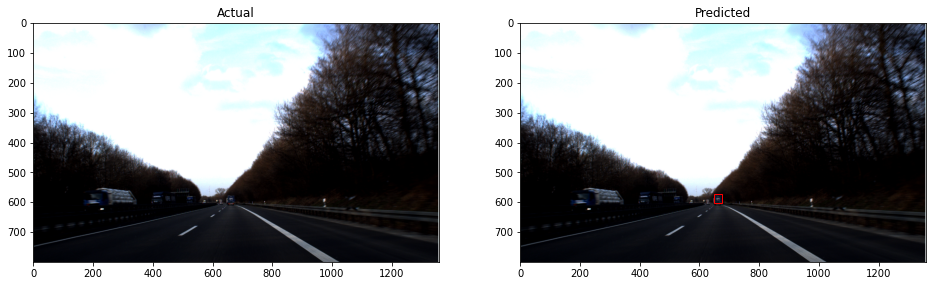

15 [7 7 5]


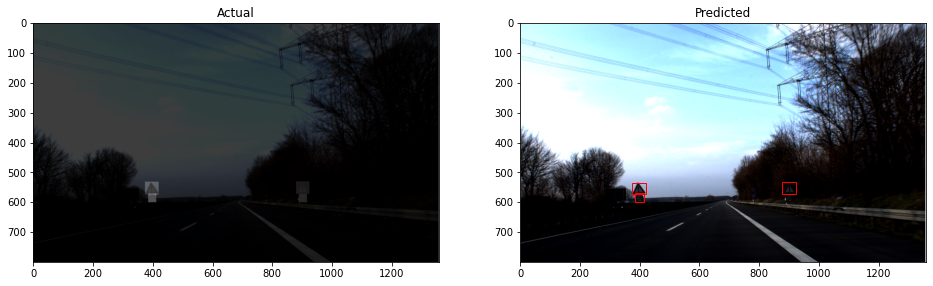

16 [2 5 2 3 5 5]


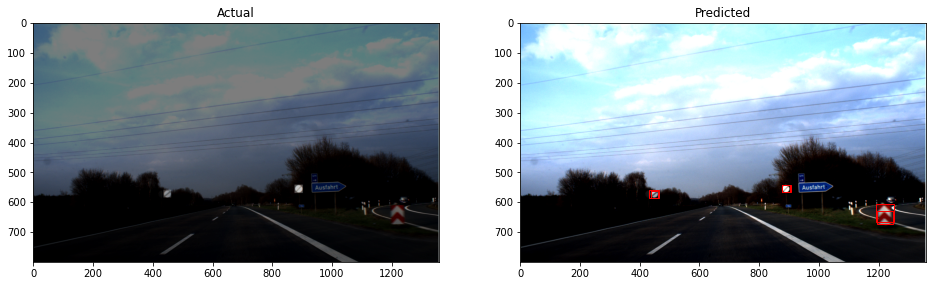

17 [8]


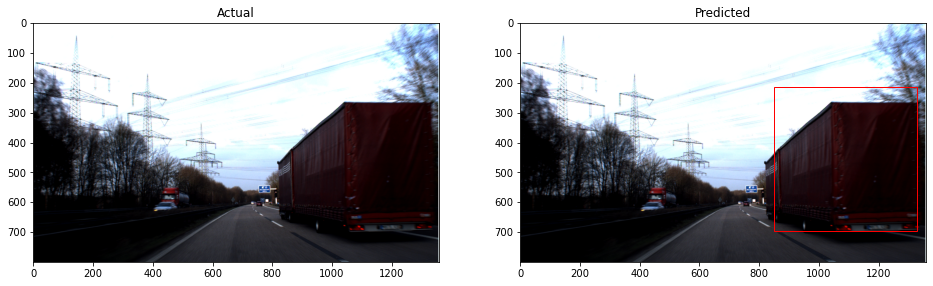

18 [5 1]


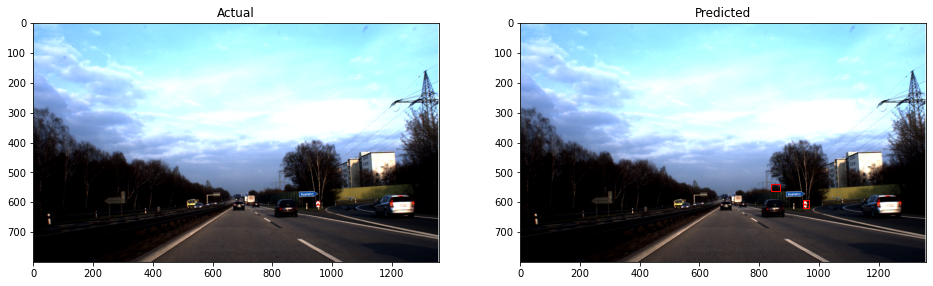

19 [6]


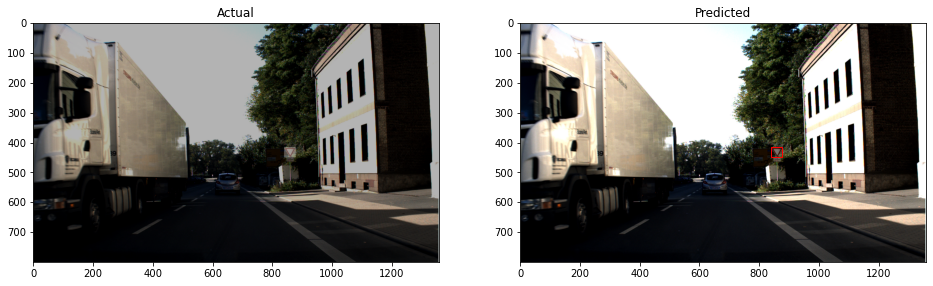

In [21]:
#plot first 20 test images
for i in range(20):
    plot_actual_vs_predicted(test_set, model_inf, cfg,n_start=i,n_images = 1)


## Output fit masks
To account for overlapping boxes, if the IoU of two masks was greater than 0.4, the average of boundaries would be taken to obtain a single mask. Depending on the image and label configuration, the amount of false boxes in an image ranges from ~0.5~1.3 extra masks per image. The best setups (maximizing total accuracy or reducing extra boxes) when input to the CNN returns 0.25-0.50 extra boxes not seen as background per image. 

This first extracts the ROIs from the predictions, and removes redundant boxes by doing a pseudo average. These are then output into a text file to be processed in the final step of the pipeline. 

In [22]:
image = test_set.load_image(1)
mask, _ = test_set.load_mask(1)
# convert pixel values (e.g. center)
scaled_image = mold_image(image, cfg)
# convert image into one sample
sample = expand_dims(scaled_image, 0)
# make prediction
yhat = model_inf.detect(sample, verbose=0)[0]

yhat['rois']

array([[ 446,   83,  506,  145],
       [ 175, 1189,  194, 1216]])

In [23]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [24]:
f_out = open(f'FullIJCNN2013/preds/box_list_sub_norm.txt','w')

for i in range(900):
    image_id = str(i).rjust(5,'0')
    if i <600:
        image = train_set.load_image(i)
    else:
        image = test_set.load_image(i-600)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model_inf.detect(sample, verbose=0)[0]
    roi_list = []
    
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        roi_list.append([x1,y1,x2,y2])
    
    #Check for redundancies
    for j in range(len(roi_list)):
        for k in range(j+1,len(roi_list)):
            if bb_intersection_over_union(roi_list[j],roi_list[k])>0.6:
                x1, y1, x2, y2 = roi_list[j]
                x3, y3, x4, y4 = roi_list[k]
                roi_list[j] = [(x1+x3)/2,(y1+y3)/2,(x2+x4)/2,(y2+y4)/2]
                roi_list[k] = [0,0,1,1]
    #For boxes not zeroed out, save to output
    for j in roi_list:
        if j[0] != 0:
            f_out.write(f'{image_id}.ppm;{int(j[0])};{int(j[1])};{int(j[2])};{int(j[3])}\n')
f_out.close()

0.0


In [25]:
f_out.close()